In [28]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import optax

In [29]:
# definition of approximant at a specific grid of points
def collocation_points(t, data, num_points):
    """
    Generate collocation points and corresponding derivatives using cubic splines.
    Args:
        t (array-like of shape n): time points at which the original data is sampled
        data (array-like of shape (n, m)): data points 
        num_points (int): number of collocation points to generate

    Returns:
        collocation_t (ndarray of shape (num_points,)): array of evenly spaced collocation time points.
        collocation_data (ndarray of shape (num_points, m)) : interpolated data values at the collocation points
        collocation_derivative (ndarray of shape (num_points, m)) : first derivatives of the interpolated data at the collocation points
    """
    # fit cspline to data
    spline = CubicSpline(t, data)
    # generate collocation points
    collocation_t = np.linspace(t[0], t[-1], num_points)
    # evaluate spline at collocation points
    collocation_data = spline(collocation_t)
    # evaluate derivative of spline at coll. pts
    collocation_derivative = spline(collocation_t, 1)
    return collocation_t, collocation_data, collocation_derivative

flask

In [30]:
# parameter initialization
def init_nn_params(layer_widths, key):
    """
        Initialize the params and return them as a list of tuples of (weight, bias) pairs
    """
    params = []
    # for each sequential pair of layer widths
    for m, n in zip(layer_widths[:-1], layer_widths[1:]):
        # split key into two new keys
        key, subkey = jax.random.split(key)
        # Xavier initialization
        weight = jax.random.normal(subkey, (m, n)) / np.sqrt(m)
        bias = jnp.zeros(n)
        # append to the list 
        params.append((weight, bias))
    return params

#### The Neural Network will be used to predict the derivatives

In [31]:
# forward pass
def nn_forward(params, x):
    activations = x
    # hidden layers
    for w, b in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, w) + b)
    # output layer params
    final_w, final_b = params[-1]
    return jnp.dot(activations, final_w) + final_b

### ref: odeint documentation
def odeint(**`func`**, y0, t, *args, rtol=1.4e-8, atol=1.4e-8, mxstep=jnp.inf, hmax=jnp.inf): <br>
*Adaptive stepsize (Dormand-Prince) Runge-Kutta odeint implementation.*

**`func`**: function to evaluate the time derivative of the solution `y` at time
      `t` as `func(y, t, *args)`, producing the same shape/structure as `y0`. <br>
**`y0`**: array or pytree of arrays representing the initial value for the state. <br>
**`t`**: array of float times for evaluation, like `jnp.linspace(0., 10., 101)`,
in which the values must be strictly increasing.

## Loss functions 

In [32]:

# loss (collocation method)
def loss_collocation(params, collocation_t, collocation_data, collocation_derivative):
    pred_derivative = []
    # loop over each collocation data point
    for data_point in collocation_data:
        # compute derivative for each data point using the neural network
        derivative = nn_forward(params, data_point)
        pred_derivative.append(derivative)

    # convert to a JAX array
    pred_derivative = jnp.array(pred_derivative)

    # loss - MSE between predicted derivative and collocation derivative
    # jnp.norm
    return jnp.mean((pred_derivative - collocation_derivative) ** 2)

# loss (ODE solver)
def loss_standard(params, t, observed_data, y0):
    """
    Args:
        params: parameters of the neural network
        t (array): array of time points at which to solve the ODE
        observed_data: observed data points (true solution of the ODE at time points t)
        y0: initial state of the system
    """
    def func(y, t):
        return nn_forward(params, y)
    
    # use "odeint" to solve the ODE given the current state of the system
    pred_solution = odeint(func, y0, t)
    return jnp.mean((pred_solution - observed_data) ** 2)

### Training NODE
`Optax` is a gradient processing and optimization library for JAX <br>
https://github.com/google-deepmind/optax

`@jit`: JIT (Just-In-Time) compilation decorator from JAX to optimize the function for performance.

`jax.value_and_grad` computes loss and its gradients wrt the neural network params

In [33]:
# Create a function that evaluates both fun and the gradient of fun
display(loss_collocation)
display(jax.value_and_grad(loss_collocation))

<function __main__.loss_collocation(params, collocation_t, collocation_data, collocation_derivative)>

<function __main__.loss_collocation(params, collocation_t, collocation_data, collocation_derivative)>

### Training: collocation

In [34]:
# train the neural ODE with collocation method
def train_nn_collocation(params, collocation_t, collocation_data, collocation_derivative, lr=1e-3, num_epochs=1000):
    """
    
    """
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    @jit
    # @inline - look look into LBM package
    def step(params, opt_state):
        # pass in params, collocation data, and collocation derivative to compute loss and gradients
        loss, grads = jax.value_and_grad(loss_collocation)(params, collocation_t, collocation_data, collocation_derivative)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    for epoch in range(num_epochs):
        loss, params, opt_state = step(params, opt_state)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return params

### Training: ODE solver

In [35]:
# train the neural ODE with ODE sovler approach
def train_nn_standard(params, t, observed_data, y0, lr=1e-3, num_epochs=1000):
    """
        params: Initial parameters of the neural network.
        t: Time points at which to solve the ODE.
        observed_data: Observed data points (true solution of the ODE).
        y0: Initial state of the system.
        lr: Learning rate for the optimizer (default is 0.001).
        num_epochs: Number of training epochs (default is 1000).
    """
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    @jit
    def step(params, opt_state):
        # loss function requires different params
        loss, grads = jax.value_and_grad(loss_standard)(params, t, observed_data, y0)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    for epoch in range(num_epochs):
        loss, params, opt_state = step(params, opt_state)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return params

In [36]:
# plotting functions
def plot_trajectory(t, true_solution, pred_solution, title):
    plt.figure(figsize=(10, 5))
    plt.plot(t, true_solution[:, 0], label='True X(t)', color='blue')
    plt.plot(t, true_solution[:, 1], label='True Y(t)', color='orange')
    plt.plot(t, pred_solution[:, 0], '--', label='Predicted X(t)', color='darkblue', alpha=0.6)
    plt.plot(t, pred_solution[:, 1], '--', label='Predicted Y(t)', color='orange', alpha=0.6)
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_phase_space(true_solution, pred_solution, title):
    plt.figure(figsize=(5, 5))
    plt.plot(true_solution[:, 0], true_solution[:, 1], label='True Trajectory', color='blue')
    plt.plot(pred_solution[:, 0], pred_solution[:, 1], '--', label='Predicted Trajectory', color='orange')
    plt.xlabel('X(t)')
    plt.ylabel('Y(t)')
    plt.title(title)
    plt.legend(loc='upper right')  # Position the legend in the upper right-hand corner
    plt.show()


### Define the system

In [37]:
def damped_harmonic_oscillator(state, t, omega_squared, c):
    x1, x2 = state
    dx1dt = x2
    dx2dt = -omega_squared * x1 - c * x2
    return jnp.array([dx1dt, dx2dt])


In [39]:
"""def damped_oscillator(y, t):
    X, Y = y
    dXdt = -0.1 * X**3 - 2 * Y**3
    dYdt = 2 * X**3 - 0.1 * Y**3
    return jnp.array([dXdt, dYdt])"""

'def damped_oscillator(y, t):\n    X, Y = y\n    dXdt = -0.1 * X**3 - 2 * Y**3\n    dYdt = 2 * X**3 - 0.1 * Y**3\n    return jnp.array([dXdt, dYdt])'

### Steps
* generate true data using `odeint`
* generate collocation pints from the data
* initialize params for nn
* train nn 

### Data Generation

In [40]:
# generate data for Damped Oscillator
n_points = 100
t = jnp.linspace(0, 10, n_points) # points at which to solve the ODE
y0 = jnp.array([1.0, 0.0]) # initial state

# coefficients
omega_squared_true = 4.0
c_true = 0.1 

# solve the ODE
y = odeint(damped_harmonic_oscillator, y0, t, omega_squared_true, c_true)

layer_widths = [2, 100, 100, 2]

### Collocation/ Smoothing Approach

In [41]:
%%time
# collocations points for Damped Oscillator
collocation_t, collocation_data, collocation_derivative = collocation_points(t, y, 100)

params_collocation = init_nn_params(layer_widths, jax.random.PRNGKey(0))
trained_params_collocation = train_nn_collocation(params_collocation, collocation_t, collocation_data, collocation_derivative)

Epoch 0, Loss: 3.790149211883545
Epoch 100, Loss: 0.02468651719391346
Epoch 200, Loss: 0.01931069977581501
Epoch 300, Loss: 0.015350627712905407
Epoch 400, Loss: 0.01224827952682972
Epoch 500, Loss: 0.009736543521285057
Epoch 600, Loss: 0.007602136116474867
Epoch 700, Loss: 0.005740644875913858
Epoch 800, Loss: 0.004126576241105795
Epoch 900, Loss: 0.002785022836178541
CPU times: user 5.21 s, sys: 410 ms, total: 5.62 s
Wall time: 5.08 s


In [42]:
## Memory
"""from memory_profiler import memory_usage

def train_model():
    params_collocation = init_nn_params(layer_widths, jax.random.PRNGKey(0))
    trained_params_collocation = train_nn_collocation(params_collocation, collocation_t, collocation_data, collocation_derivative)

# Measure peak memory usage during the training process
mem_usage = memory_usage(proc=train_model, interval=1, timeout=None)
print(f"Peak memory usage: {max(mem_usage)} MB")"""

'from memory_profiler import memory_usage\n\ndef train_model():\n    params_collocation = init_nn_params(layer_widths, jax.random.PRNGKey(0))\n    trained_params_collocation = train_nn_collocation(params_collocation, collocation_t, collocation_data, collocation_derivative)\n\n# Measure peak memory usage during the training process\nmem_usage = memory_usage(proc=train_model, interval=1, timeout=None)\nprint(f"Peak memory usage: {max(mem_usage)} MB")'

### Standard Approach

In [43]:
%%time
# Initialize and train neural network for Damped Oscillator using Standard ODE Solver Approach
params_standard = init_nn_params(layer_widths, jax.random.PRNGKey(0))
trained_params_standard = train_nn_standard(params_standard, t, y, y0)

Epoch 0, Loss: 15.343649864196777
Epoch 100, Loss: 0.7800465226173401
Epoch 200, Loss: 0.7709776163101196
Epoch 300, Loss: 0.7619431614875793
Epoch 400, Loss: 0.7526791095733643
Epoch 500, Loss: 0.7419444918632507
Epoch 600, Loss: 0.7254323959350586
Epoch 700, Loss: 0.6777646541595459
Epoch 800, Loss: 0.7639625668525696
Epoch 900, Loss: 0.7630818486213684
CPU times: user 43.9 s, sys: 789 ms, total: 44.7 s
Wall time: 44.7 s


### Memory

In [25]:
"""from memory_profiler import memory_usage

def train_model():
    params_standard = init_nn_params(layer_widths, jax.random.PRNGKey(0))
    trained_params_standard = train_nn_standard(params_standard, t, y, y0)

# Measure peak memory usage during the training process
mem_usage = memory_usage(proc=train_model, interval=1, timeout=None)
print(f"Peak memory usage: {max(mem_usage)} MB")
"""

Epoch 0, Loss: 14.304691314697266
Epoch 100, Loss: 0.25618475675582886
Epoch 200, Loss: 0.1829606145620346
Epoch 300, Loss: 0.12519942224025726


2024-06-02 13:48:34.556867: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m5.482424s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Epoch 400, Loss: 0.083552785217762
Epoch 500, Loss: 0.06724485009908676


2024-06-02 14:08:08.218028: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 16m51.55782s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-06-02 14:34:25.501676: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 9m16.623081s

********************************
[Compiling module jit__odeint_wrapper] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Epoch 600, Loss: 0.059358008205890656
Epoch 700, Loss: 0.05403180792927742
Epoch 800, Loss: 0.04977356642484665
Epoch 900, Loss: 0.04602283239364624
Peak memory usage: 5591.6875 MB


In [23]:
# solve the ODE using the neural network
def neural_ode(params, y0, t):
    def func(y, t):
        return nn_forward(params, y)
    # pass in the trained model as the derivative function
    return odeint(func, y0, t)

## Damped Oscillator

### omega_squared_true = 4.0

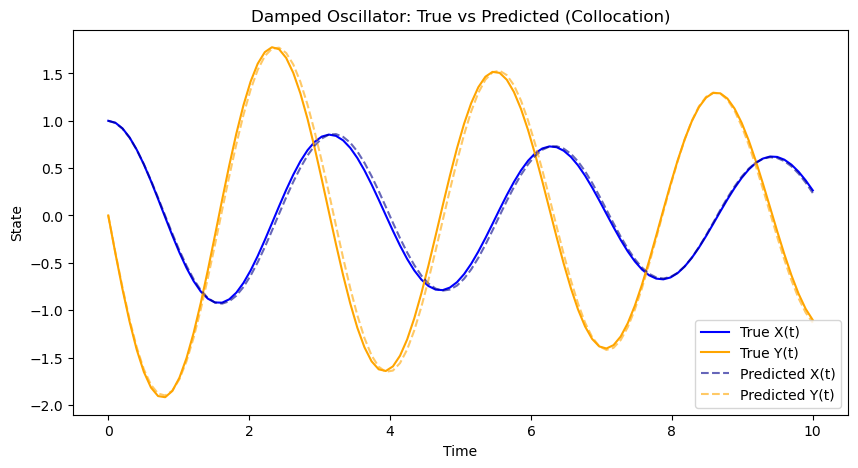

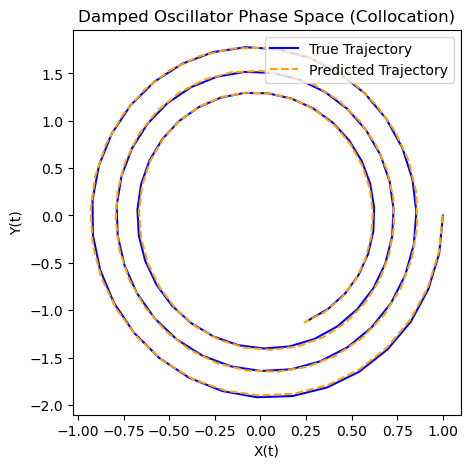

In [44]:
# Generate predicted solution for Damped Oscillator using both methods
pred_solution_damped_collocation = neural_ode(trained_params_collocation, y0, t)

# Plot the results for Damped Oscillator
plot_trajectory(t, y, pred_solution_damped_collocation, 'Damped Oscillator: True vs Predicted (Collocation)')
plot_phase_space(y, pred_solution_damped_collocation, 'Damped Oscillator Phase Space (Collocation)')

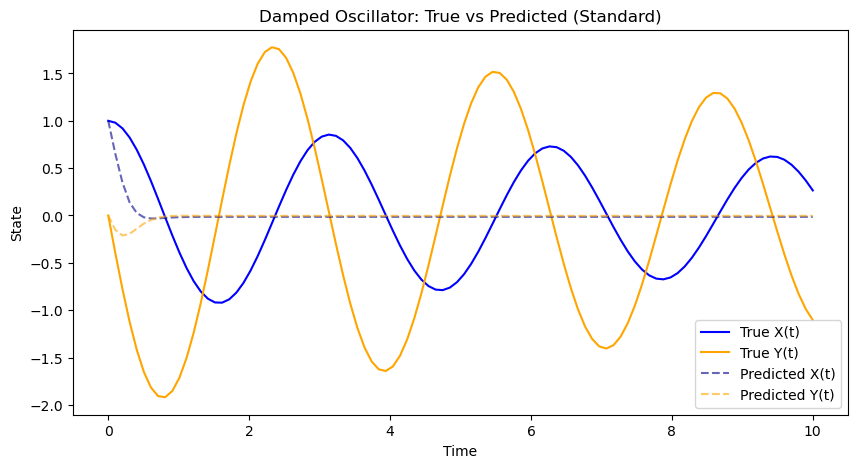

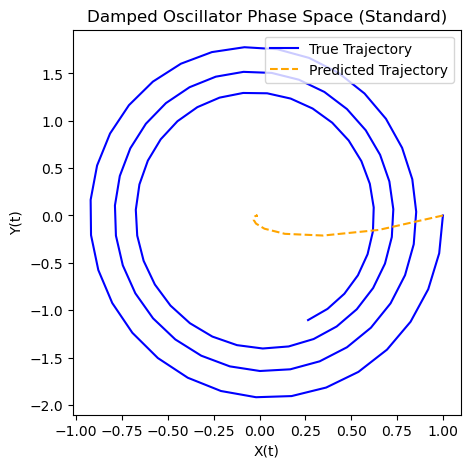

In [27]:
pred_solution_damped_standard = neural_ode(trained_params_standard, y0, t)

plot_trajectory(t, y, pred_solution_damped_standard, 'Damped Oscillator: True vs Predicted (Standard)')
plot_phase_space(y, pred_solution_damped_standard, 'Damped Oscillator Phase Space (Standard)')

### omega_squared_true = 1.0

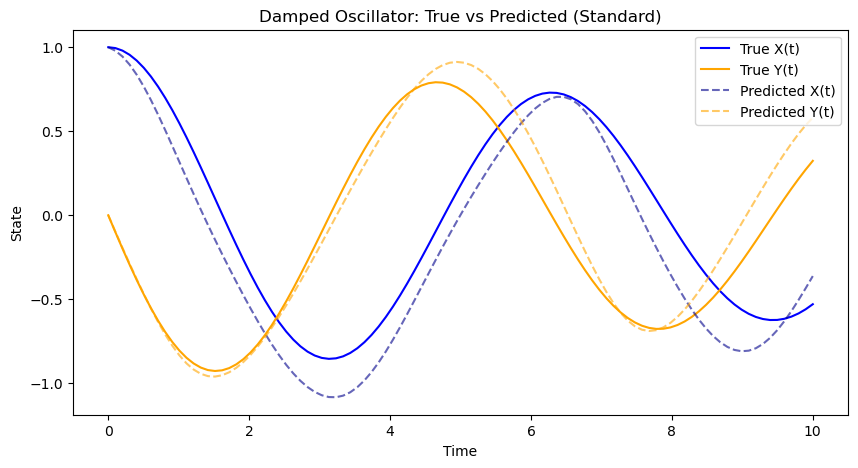

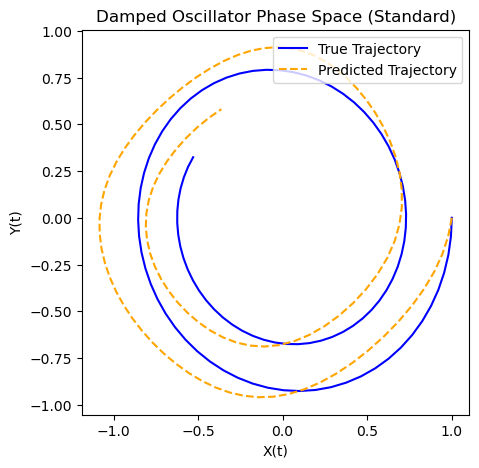

In [24]:
pred_solution_damped_standard = neural_ode(trained_params_standard, y0, t)

plot_trajectory(t, y, pred_solution_damped_standard, 'Damped Oscillator: True vs Predicted (Standard)')
plot_phase_space(y, pred_solution_damped_standard, 'Damped Oscillator Phase Space (Standard)')

## Van der Pol Oscillator

In [25]:
# eg: Van der Pol Oscillator
def van_der_pol(y, t, mu=1.0):
    X, Y = y
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X
    return jnp.array([dXdt, dYdt])

# training data 
t = jnp.linspace(0, 10, 200)
y0 = jnp.array([2.0, 0.0])
y = odeint(van_der_pol, y0, t)

# collocation points for Van der Pol Oscillator
collocation_t, collocation_data, collocation_derivative = collocation_points(t, y, 200)

In [26]:
params_collocation = init_nn_params(layer_widths, jax.random.PRNGKey(0))
trained_params_collocation = train_nn_collocation(params_collocation, collocation_t, collocation_data, collocation_derivative)

Epoch 0, Loss: 4.0401530265808105
Epoch 100, Loss: 0.011062243022024632
Epoch 200, Loss: 0.0018892129883170128
Epoch 300, Loss: 0.0009250546572729945
Epoch 400, Loss: 0.0005668434896506369
Epoch 500, Loss: 0.00037031248211860657
Epoch 600, Loss: 0.00025106663815677166
Epoch 700, Loss: 0.000178065340151079
Epoch 800, Loss: 0.00013350257358979434
Epoch 900, Loss: 0.00010567811841610819


In [27]:
params_standard = init_nn_params(layer_widths, jax.random.PRNGKey(0))
trained_params_standard = train_nn_standard(params_standard, t, y, y0)

Epoch 0, Loss: 22.462005615234375
Epoch 100, Loss: 1.884129285812378
Epoch 200, Loss: 1.8135759830474854
Epoch 300, Loss: 1.6304978132247925
Epoch 400, Loss: 0.151630699634552
Epoch 500, Loss: 0.12035417556762695
Epoch 600, Loss: 0.13491064310073853
Epoch 700, Loss: 0.1055707335472107
Epoch 800, Loss: 0.12159129977226257
Epoch 900, Loss: 0.10575579106807709


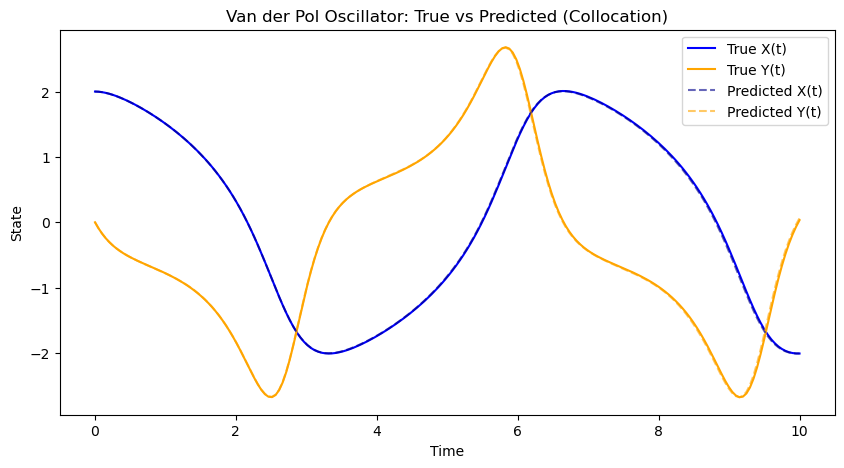

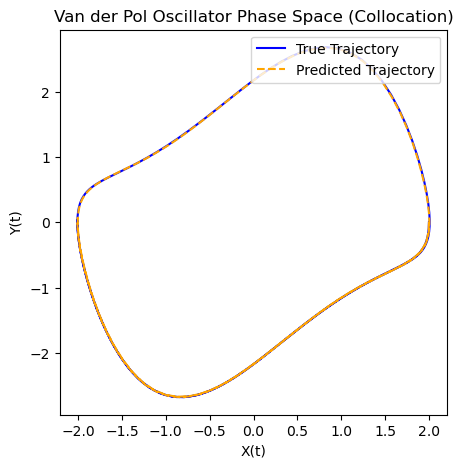

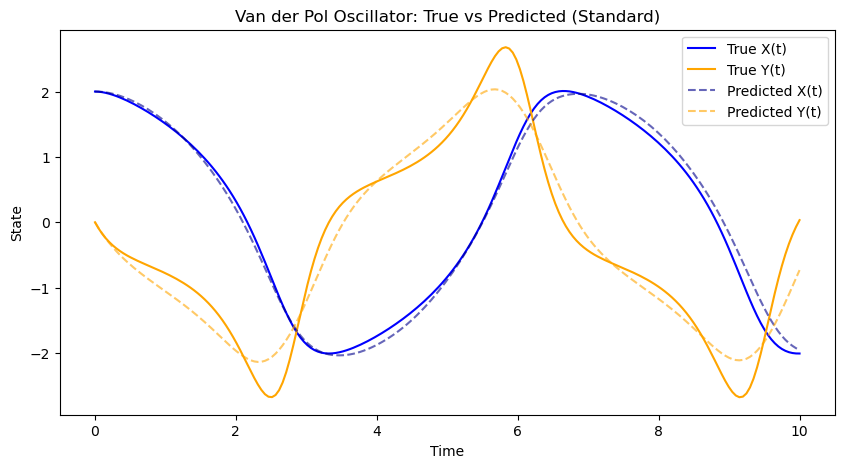

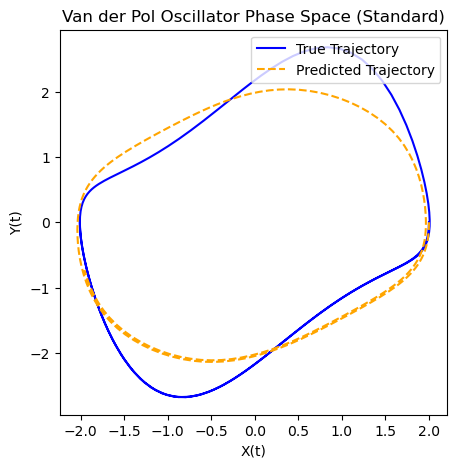

In [28]:
pred_solution_vdp_collocation = neural_ode(trained_params_collocation, y0, t)
pred_solution_vdp_standard = neural_ode(trained_params_standard, y0, t)

# Plot the results for Van der Pol Oscillator
plot_trajectory(t, y, pred_solution_vdp_collocation, 'Van der Pol Oscillator: True vs Predicted (Collocation)')
plot_phase_space(y, pred_solution_vdp_collocation, 'Van der Pol Oscillator Phase Space (Collocation)')

plot_trajectory(t, y, pred_solution_vdp_standard, 'Van der Pol Oscillator: True vs Predicted (Standard)')
plot_phase_space(y, pred_solution_vdp_standard, 'Van der Pol Oscillator Phase Space (Standard)')
